In [19]:
import yaml
import awkward as aw
import uproot
from util import get_minit_from_procces_file, save_array_to_file, significance, get_cutted_files
import hist
import math
import numpy as np
from scipy.stats import kstest
from sklearn.neural_network import MLPRegressor
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import RocCurveDisplay
import cloudpickle
import plotly.graph_objects as go
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import xgboost as xgb


In [20]:
with open('config.yaml') as conf_file:
    config = yaml.load(conf_file, Loader=yaml.Loader) 


In [21]:
do_cut = 0
with_VBF_cut = False
if with_VBF_cut:
    VBF_cut = '_with_VBF_cut'
else:
    VBF_cut = '_without_VBF_cut'


In [13]:

BDT_inputs = ['mjj', "dphijj", "detajj",
              'MET',
              'jet1_pt','jet1_eta','jet1_e',
              'jet2_pt','jet2_eta','jet2_e',
            #    "njet30", 
              "centrality"
             ]
#Load trained model and scaler to normalize data
path = "models/div1/centrality/"
name = "BDT_model_centrality_final.pkl"
# path = "models/div1/"
# name = "BDT_model_less_variables.pkl"
# name = "BDT_model_final.pkl"
reg = cloudpickle.load(open(path+name, 'rb'))
# scaler = cloudpickle.load(open('scaler.pkl', 'rb'))


### Plots with unseen data
Generating plots from testing data

In [14]:
# load numpy array from npy file
from numpy import load
# load array
path = "output/xgboost/centrality/"
x_test = load(path+'x_test.npy')
y_test = load(path+"y_test.npy")
w_test = load(path+'w_test.npy')

x_val = load(path+'x_val.npy')
y_val = load(path+"y_val.npy")
w_val = load(path+'w_val.npy')
path = "output/xgboost/centrality/"
b_e_less_2jets = np.load(path+"b_test_1_0_jets.npy")
# x_test_bg = load(path+'x_test_bg.npy')
# y_test_bg = load(path+"y_test_bg.npy")
# w_test_bg = load(path+'w_test_bg.npy')


In [15]:
# y_b es ggF
# y_bg es background
y_pred_test = reg.predict(x_test)
y_s = len(y_test[y_test==1])
y_b = len(y_test[y_test==0])
y_s_w = np.sum(w_test[y_test==1])
y_b_w = np.sum(w_test[y_test==0])

y_pred_val = reg.predict(x_val).flatten()

# extra ggF events with less than 2 jets
# This events are previusly classified as ggF events
w_extra = b_e_less_2jets["weight"]
y_extra = np.zeros(len(b_e_less_2jets))


# y_pred_test_bg = reg.predict(x_test_bg)
# y_bg_w = np.sum(w_test_bg)

In [16]:
def puntaje_corte(s_as_s, s, b_as_b,b):
    # fraccion de señal bien identificada
    x = s_as_s/s
    #fraccion de background bien identificada
    y = b_as_b/b
    #distancia al punto maximo
    r = np.sqrt((1-x)**2 + (1-y)**2)
    # 1-r porque queremos que el puntaje aumente pare mejores cortes
    # mejor puntaje sera 1, el peor sera 0
    return 1-r, x, y
best_mc_score = [0]
best_w_score = [0]
best_mc_cut = 0
best_w_cut = 0
y_s_w = np.sum(w_val[y_val==1])
y_b_w = np.sum(w_val[y_val==0])
for cut in np.linspace(0,1,201):
    #all events predicted as vbf
    y_pred_s = y_val[y_pred_val>cut]
    # mc vbf events predicted as vbf
    s_as_s = len(y_pred_s[y_pred_s==1])
    #weights of events predicted as vbf
    w_pred_as_s = w_val[y_pred_val>cut]
    #weighted vbf events predicted as vbf
    s_as_s_w = np.sum(w_pred_as_s[y_pred_s==1])

    #all events predicted as ggf
    y_pred_b = y_val[y_pred_val<cut]
    # mc ggf events predicted as ggf
    b_as_b = len(y_pred_b[y_pred_b==0])
    #weights of events predicted as ggf
    w_pred_as_b = w_val[y_pred_val<cut]
    #weighted ggf events predicted as ggf
    b_as_b_w = np.sum(w_pred_as_b[y_pred_b==0])

    mc_score = puntaje_corte(s_as_s,y_s, b_as_b, y_b)
    w_score = puntaje_corte(s_as_s_w, y_s_w, b_as_b_w, y_b_w)
    if mc_score[0]> best_mc_score[0]:
        best_mc_cut = cut
        best_mc_score = mc_score
    if w_score[0]> best_w_score[0]:
        best_w_score = w_score
        best_w_cut = cut
print(f"best mc cut is {best_mc_cut} with score {best_mc_score[0]}, frac_vbf: {best_mc_score[1]}, \
frac_ggf: {best_mc_score[2]}")
print(f"best w_cut is {best_w_cut} with score {best_w_score[0]}, frac_vbf: {best_w_score[1]}, \
frac_ggf: {best_w_score[2]}")

best mc cut is 0.445 with score 0.9016509612668394, frac_vbf: 0.9277597512795797, frac_ggf: 0.9332626050512268
best w_cut is 0.47500000000000003 with score 0.9037105645976328, frac_vbf: 0.9266343712806702, frac_ggf: 0.9376370310783386


Confusion matrix, without normalization
[[214112  13991]
 [  5814  67843]]
Normalized confusion matrix
[[0.93866367 0.06133633]
 [0.07893343 0.92106657]]
Weighted confusion matrix, without normalization
[[3.01358798e+05 2.00915310e+04]
 [1.26193113e+02 1.50125073e+03]]
Weighted normalized confusion matrix
[[0.93749725 0.06250275]
 [0.07754069 0.92245931]]


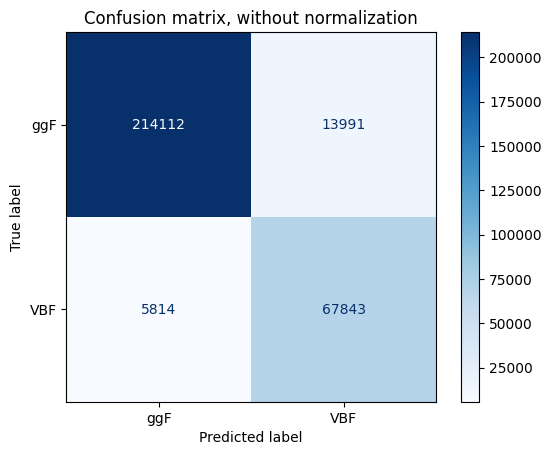

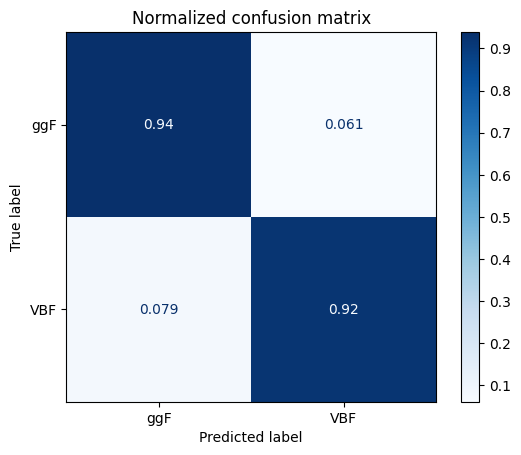

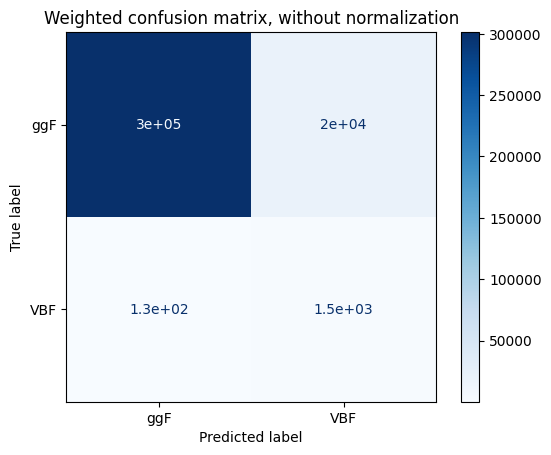

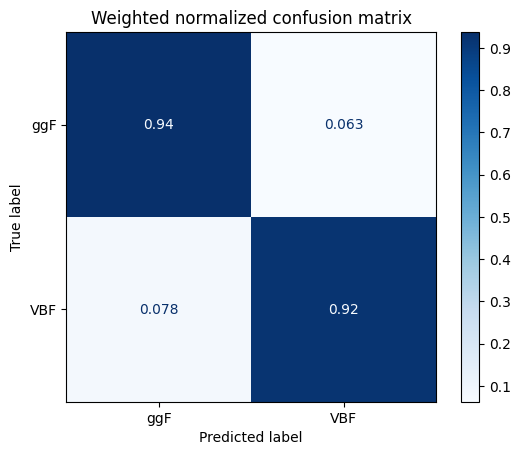

In [17]:
division_cut = best_w_cut
y_class = y_pred_test.copy()
# y_class_bg = y_pred_test_bg.copy()
y_class[y_pred_test>division_cut]=1.0
y_class[y_pred_test<=division_cut]=0.0
# y_class_bg[y_pred_test_bg>division_cut]=1.0
# y_class_bg[y_pred_test_bg<=division_cut]=0.0
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None, None),
                  ("Normalized confusion matrix", 'true', None),
                  ("Weighted confusion matrix, without normalization", None, w_test),
                  ("Weighted normalized confusion matrix", 'true', w_test)]
for title, normalize, w in titles_options:
    # disp = plot_confusion_matrix(reg, X_test, Y_test,
    #                              #display_labels=class_names,
    #                              cmap=plt.cm.Blues,
    #                              normalize=normalize)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_class,
                                 normalize=normalize, 
                                 sample_weight=w,
                                 display_labels = ["ggF","VBF"],
                                 cmap=plt.cm.Blues)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
del title, normalize, w
# disp_bg = ConfusionMatrixDisplay.from_predictions(y_test_bg, y_class_bg,
#                                  normalize=None, 
#                                  sample_weight=w_test_bg,
#                                  display_labels = ["ggF","VBF"],
#                                  cmap=plt.cm.Blues)
# print(disp_bg.confusion_matrix/np.sum(w_test_bg))
plt.show()

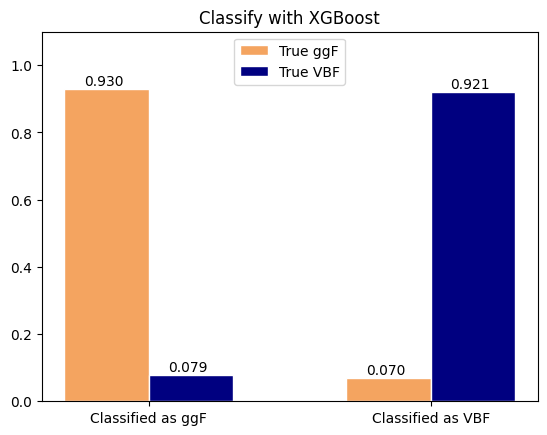

In [10]:
barWidth = 0.3
xh = 0.08
labels = ["Classified as ggF", "Classified as VBF"]
ggf_as_ggf_bdt = disp.confusion_matrix[0,0]
ggf_as_vbf_bdt = disp.confusion_matrix[0,1]
vbf_as_ggf_bdt = disp.confusion_matrix[1,0]
vbf_as_vbf_bdt = disp.confusion_matrix[1,1]
# bg_as_vbf_bdt = disp_bg.confusion_matrix[0,1]/w_true_bg
# bg_as_ggf_bdt = disp_bg.confusion_matrix[0,0]/w_true_bg
bars1 = [ggf_as_ggf_bdt, ggf_as_vbf_bdt]
bars2 = [vbf_as_ggf_bdt, vbf_as_vbf_bdt]
# bars3 = [bg_as_ggf_bdt, bg_as_vbf_bdt]
title = "Classify with XGBoost"
plot_name = "bdt_cut_barplot"
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
# r3 = [x + barWidth for x in r2]

# Make the plot
plt.figure()
plt.bar(r1, bars1, color='sandybrown', width=barWidth, edgecolor='white', label='True ggF')
plt.bar(r2, bars2, width=barWidth, color="navy", edgecolor='white', label='True VBF')
# plt.bar(r3, bars3, width=barWidth, color='firebrick', edgecolor='white', label='Background')
plt.title(title)
# Add xticks on the middle of the group bars
# plt.xlabel('Classification', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], labels)
bars11 = np.concatenate((bars1,bars2))#,bars3))
r11 = np.concatenate((r1,r2))#,r3))
plt.ylim(0,1.1)
for j, v in enumerate(bars11):
    if v > 0.95:
        plt.text(r11[j] - xh, v - 0.05, f"{v:.3f}")
    else:
        plt.text(r11[j] - xh, v + 0.01, f"{v:.3f}")

# Create legend & Show graphic
plt.legend(loc='upper center')

Confusion matrix, without normalization
[[186322   4603]
 [  2441  27360]]
Normalized confusion matrix
[[0.97589106 0.02410894]
 [0.08191    0.91809   ]]
Weighted confusion matrix, without normalization
[[2.75663826e+05 6.66134542e+03]
 [5.21253617e+01 6.04824653e+02]]
Weighted normalized confusion matrix
[[0.97640541 0.02359459]
 [0.07934449 0.92065551]]


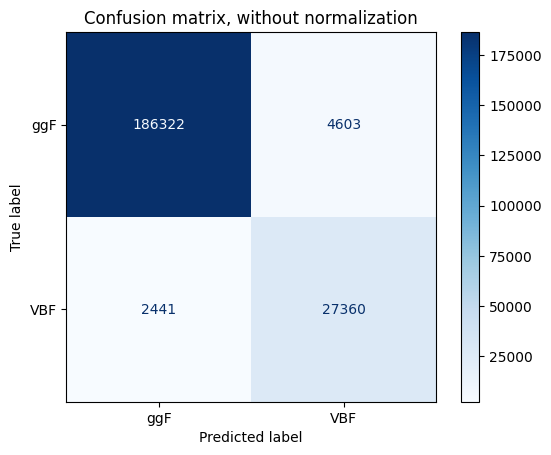

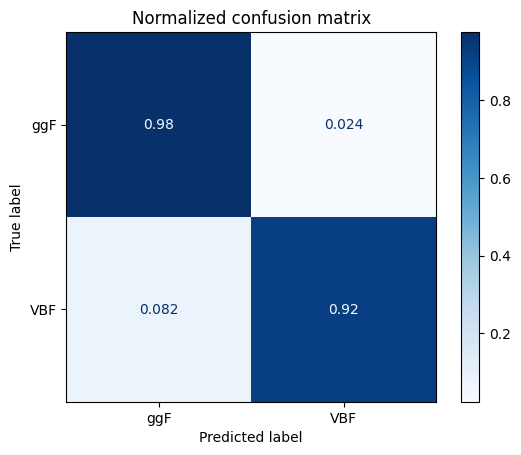

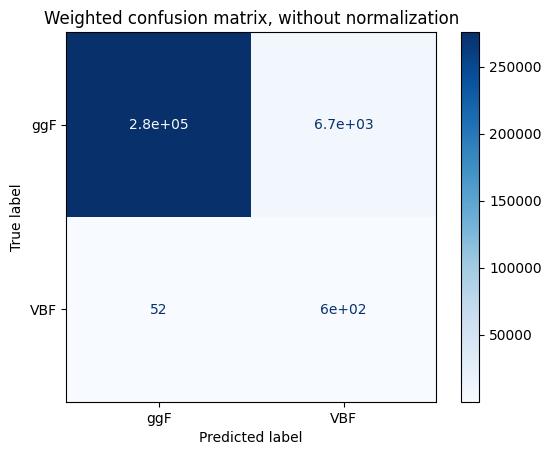

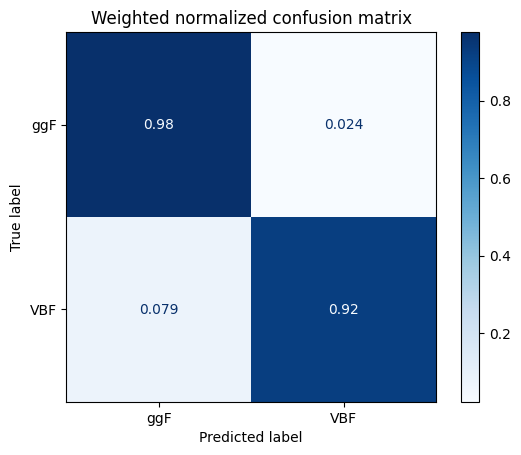

In [11]:
# Adding pre classified ggF events
y_extra = np.zeros(len(b_e_less_2jets))
y_class_2 = np.concatenate((y_class, y_extra))
w_test_2 = np.concatenate((w_test, w_extra))
y_test_2 = np.concatenate((y_test,y_extra))
titles_options = [("Confusion matrix, without normalization", None, None),
                  ("Normalized confusion matrix", 'true', None),
                  ("Weighted confusion matrix, without normalization", None, w_test_2),
                  ("Weighted normalized confusion matrix", 'true', w_test_2)]
for title, normalize, w in titles_options:
    # disp = plot_confusion_matrix(reg, X_test, Y_test,
    #                              #display_labels=class_names,
    #                              cmap=plt.cm.Blues,
    #                              normalize=normalize)
    disp = ConfusionMatrixDisplay.from_predictions(y_test_2, y_class_2,
                                 normalize=normalize, 
                                 sample_weight=w,
                                 display_labels = ["ggF","VBF"],
                                 cmap=plt.cm.Blues)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
del title, normalize, w
# disp_bg = ConfusionMatrixDisplay.from_predictions(y_test_bg, y_class_bg,
                                #  normalize=None, 
                                #  sample_weight=w_test_bg,
                                #  display_labels = ["ggF","VBF"],
                                #  cmap=plt.cm.Blues)
# print(disp_bg.confusion_matrix/np.sum(w_test_bg))
plt.show()

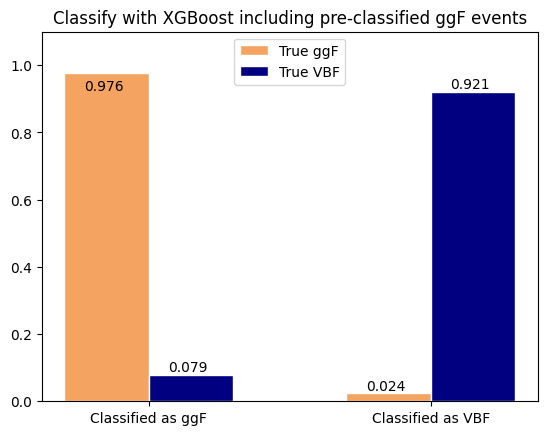

In [12]:
barWidth = 0.3
xh = 0.08
labels = ["Classified as ggF", "Classified as VBF"]
ggf_as_ggf_bdt = disp.confusion_matrix[0,0]
ggf_as_vbf_bdt = disp.confusion_matrix[0,1]
vbf_as_ggf_bdt = disp.confusion_matrix[1,0]
vbf_as_vbf_bdt = disp.confusion_matrix[1,1]
# bg_as_vbf_bdt = disp_bg.confusion_matrix[0,1]/w_true_bg
# bg_as_ggf_bdt = disp_bg.confusion_matrix[0,0]/w_true_bg
bars1 = [ggf_as_ggf_bdt, ggf_as_vbf_bdt]
bars2 = [vbf_as_ggf_bdt, vbf_as_vbf_bdt]
# bars3 = [bg_as_ggf_bdt, bg_as_vbf_bdt]
title = "Classify with XGBoost including pre-classified ggF events"
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
# r3 = [x + barWidth for x in r2]

# Make the plot
plt.figure()
plt.bar(r1, bars1, color='sandybrown', width=barWidth, edgecolor='white', label='True ggF')
plt.bar(r2, bars2, width=barWidth, color="navy", edgecolor='white', label='True VBF')
# plt.bar(r3, bars3, width=barWidth, color='firebrick', edgecolor='white', label='Background')
plt.title(title)
# Add xticks on the middle of the group bars
# plt.xlabel('Classification', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], labels)
bars11 = np.concatenate((bars1,bars2))#,bars3))
r11 = np.concatenate((r1,r2))#,r3))
plt.ylim(0,1.1)
for j, v in enumerate(bars11):
    if v > 0.95:
        plt.text(r11[j] - xh, v - 0.05, f"{v:.3f}")
    else:
        plt.text(r11[j] - xh, v + 0.01, f"{v:.3f}")

# Create legend & Show graphic
plt.legend(loc='upper center')

In [9]:
cuts_config = config['cuts_config']

# guarda indices de eventos predecidos como ggf y vbf o como ninguno 
# pred_idx[0] seran usando solo el corte en la masa
# pred_idx[1] sera usando el corte en la masa y en el MET (como en la nota)
# pred_idx[2] sera usando solo el corte en MET
y_pred_cuts = [[],[],[]]
pred_vbf_idx = [[],[],[]]
pred_ggf_idx = [[],[],[]]
pred_else = [[],[],[]]

for i in range(len(y_test)):
    if  x_test[i, 0] >= cuts_config['min_mjj']:
        pred_vbf_idx[0].append(i)
        y_pred_cuts[0].append(1.0)
        # cumple ambos cortes
        if x_test[i,3] > cuts_config['min_MET']:
            pred_vbf_idx[1].append(i)
            y_pred_cuts[1].append(1.0)
            pred_vbf_idx[2].append(i)
        # cumple solo con la masa
        else:
            y_pred_cuts[1].append(2.0)
            pred_else[1].append(i)
            pred_ggf_idx[2].append(i)
        
    elif x_test[i, 0] < cuts_config['min_mjj']:
        y_pred_cuts[0].append(0.0)
        pred_ggf_idx[0].append(i)
        # no cumple ningun corte
        if x_test[i,3] <= cuts_config['min_MET']:
            y_pred_cuts[1].append(0.0)
            pred_ggf_idx[1].append(i)
            pred_ggf_idx[2].append(i)
        # cumple solo con MET
        else:
            y_pred_cuts[1].append(2.0)
            pred_else[1].append(i)
            pred_vbf_idx[2].append(i)



In [10]:
# guarda indices de eventos predecidos como ggf y vbf o como ninguno 
# pred_idx[0] seran usando solo el corte en la masa
# pred_idx[1] sera usando el corte en la masa y en el MET (como en la nota)
# pred_idx[2] sera usando solo el corte en MET
pred_vbf_idx_bg = [[],[],[]]
pred_ggf_idx_bg = [[],[],[]]
pred_else_bg = [[],[],[]]

for i in range(len(y_test_bg)):
    if  x_test_bg[i, 0] >= cuts_config['min_mjj']:
        pred_vbf_idx_bg[0].append(i)
        # cumple ambos cortes
        if x_test_bg[i,3] > cuts_config['min_MET']:
            pred_vbf_idx_bg[1].append(i)
            pred_vbf_idx_bg[2].append(i)
        # cumple solo con la masa
        else:
            pred_else_bg[1].append(i)
            pred_ggf_idx_bg[2].append(i)
        
    elif x_test_bg[i, 0] < cuts_config['min_mjj']:
        pred_ggf_idx_bg[0].append(i)
        # no cumple ningun corte
        if x_test_bg[i,3] <= cuts_config['min_MET']:
            pred_ggf_idx_bg[1].append(i)
            pred_ggf_idx_bg[2].append(i)
        # cumple solo con MET
        else:
            pred_else_bg[1].append(i)
            pred_vbf_idx_bg[2].append(i)


In [11]:
# number of MC events
m_and_MET = 1
vbf_as_vbf_cut = np.sum(y_test[pred_vbf_idx[m_and_MET]])
ggf_as_vbf_cut = len(y_test[pred_vbf_idx[m_and_MET]]) - vbf_as_vbf_cut
vbf_as_ggf_cut = np.sum(y_test[pred_ggf_idx[m_and_MET]])
ggf_as_ggf_cut = len(y_test[pred_ggf_idx[m_and_MET]])-vbf_as_ggf_cut
not_used_vbf = np.sum(y_test[pred_else[m_and_MET]])
not_used_ggf = len(y_test[pred_else[m_and_MET]]) - not_used_vbf


NameError: name 'pred_vbf_idx' is not defined

In [12]:
# weighted events
w_vbf_as_vbf=["","",""]
w_ggf_as_vbf=["","",""]
w_true_vbf = np.sum(w_test[y_test==1])
w_true_ggf = np.sum(w_test[y_test==0])
w_ggf_as_ggf=["","",""]
w_vbf_as_ggf=["","",""]
w_ggf_else=["","",""]
w_vbf_else=["","",""]
for m_and_MET in [0,1,2]:
    y_vbf = y_test[pred_vbf_idx[m_and_MET]]
    w_vbf = w_test[pred_vbf_idx[m_and_MET]]
    w_vbf_as_vbf[m_and_MET] = np.sum(w_vbf[y_vbf==1])
    w_ggf_as_vbf[m_and_MET] = np.sum(w_vbf[y_vbf==0])

    y_ggf = y_test[pred_ggf_idx[m_and_MET]]
    w_ggf = w_test[pred_ggf_idx[m_and_MET]]
    w_ggf_as_ggf[m_and_MET] = np.sum(w_ggf[y_ggf==0])
    w_vbf_as_ggf[m_and_MET] = np.sum(w_ggf[y_ggf==1])

    y_else = y_test[pred_else[m_and_MET]]
    w_esle = w_test[pred_else[m_and_MET]]
    w_ggf_else[m_and_MET] = np.sum(w_esle[y_else==0])
    w_vbf_else[m_and_MET] = np.sum(w_esle[y_else==1])

In [13]:
# weighted events for background
w_bg_as_vbf=["","",""]
w_bg_as_ggf=["","",""]
w_true_bg = np.sum(w_test_bg)
w_bg_else=["","",""]
for m_and_MET in [0,1,2]:
    # weights of background predicted as vbf
    w_bg_as_vbf[m_and_MET] = np.sum(w_test_bg[pred_vbf_idx_bg[m_and_MET]])
    # weights of background predicted as ggf
    w_bg_as_ggf[m_and_MET] = np.sum(w_test_bg[pred_ggf_idx_bg[m_and_MET]])
    # weights of background predicted as else (not used)
    w_bg_else[m_and_MET] = np.sum(w_test_bg[pred_else_bg[m_and_MET]])
    

In [14]:
print(100*w_bg_as_vbf[1]/w_true_bg)
print(w_vbf_as_vbf[1])

0.0001507611447552835
127.08649


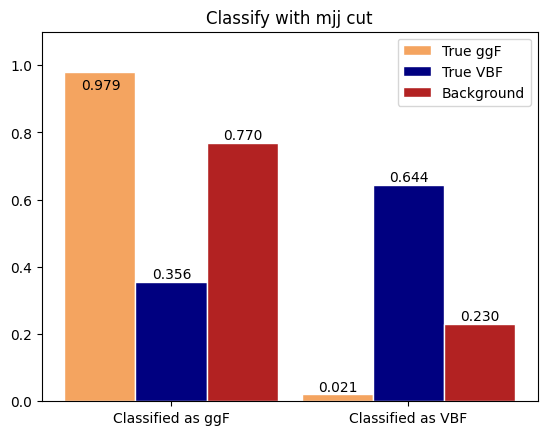

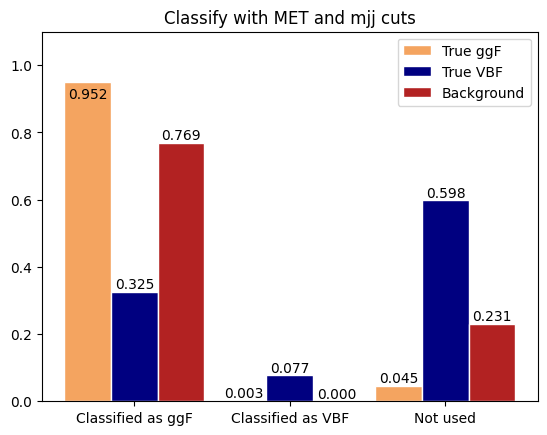

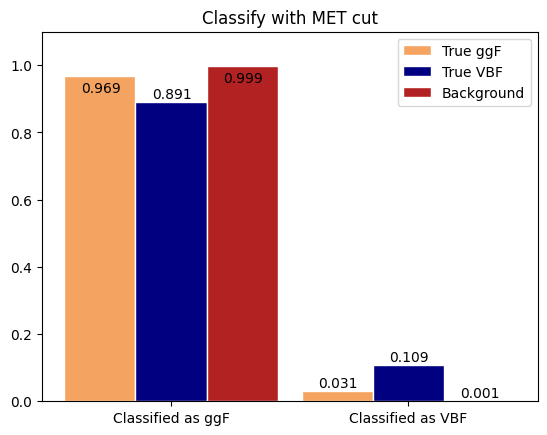

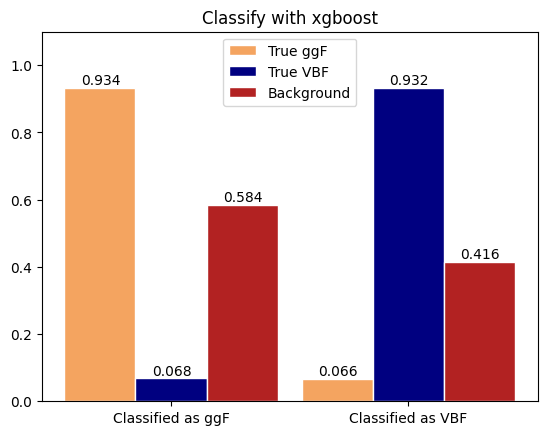

In [35]:
# plots Classify with mjj and MET cuts
for i in range(4):
    barWidth = 0.3
    if i==1:
        labels = ["Classified as ggF", "Classified as VBF", "Not used"]
        bars1 = np.array([w_ggf_as_ggf[i], w_ggf_as_vbf[i], w_ggf_else[i]])/w_true_ggf
        bars2 = np.array([w_vbf_as_ggf[i], w_vbf_as_vbf[i], w_vbf_else[i]])/w_true_vbf
        bars3 = np.array([w_bg_as_ggf[i], w_bg_as_vbf[i], w_bg_else[i]])/w_true_bg
        title = "Classify with MET and mjj cuts"
        xh = 0.125
        plot_name = "mjj_and_MET_cuts_barplot"
    elif i==3:
        ggf_as_ggf_bdt = disp.confusion_matrix[0,0]
        ggf_as_vbf_bdt = disp.confusion_matrix[0,1]
        vbf_as_ggf_bdt = disp.confusion_matrix[1,0]
        vbf_as_vbf_bdt = disp.confusion_matrix[1,1]
        bg_as_vbf_bdt = disp_bg.confusion_matrix[0,1]/w_true_bg
        bg_as_ggf_bdt = disp_bg.confusion_matrix[0,0]/w_true_bg
        bars1 = [ggf_as_ggf_bdt, ggf_as_vbf_bdt]
        bars2 = [vbf_as_ggf_bdt, vbf_as_vbf_bdt]
        bars3 = [bg_as_ggf_bdt, bg_as_vbf_bdt]
        title = "Classify with xgboost"
        plot_name = "bdt_cut_barplot"
    else:
        labels = ["Classified as ggF", "Classified as VBF"]
        bars1 = np.array([w_ggf_as_ggf[i], w_ggf_as_vbf[i]])/w_true_ggf
        bars2 = np.array([w_vbf_as_ggf[i], w_vbf_as_vbf[i]])/w_true_vbf
        bars3 = np.array([w_bg_as_ggf[i], w_bg_as_vbf[i]])/w_true_bg
        xh = 0.08
        if i==0:
            title = "Classify with mjj cut"
            plot_name = "mjj_cut_barplot"
        if i==2:
            title = "Classify with MET cut"
            plot_name = "MET_cut_barplot"        

    # Set position of bar on X axis
    # r1 = np.arange(len(bars1))
    # r2 = [x + barWidth for x in r1]

    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    # Make the plot
    plt.figure(i)
    plt.bar(r1, bars1, color='sandybrown', width=barWidth, edgecolor='white', label='True ggF')
    plt.bar(r2, bars2, width=barWidth, color="navy", edgecolor='white', label='True VBF')
    plt.bar(r3, bars3, width=barWidth, color='firebrick', edgecolor='white', label='Background')
    plt.title(title)
    # Add xticks on the middle of the group bars
    # plt.xlabel('Classification', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(bars1))], labels)
    bars11 = np.concatenate((bars1,bars2,bars3))
    r11 = np.concatenate((r1,r2,r3))
    plt.ylim(0,1.1)
    for j, v in enumerate(bars11):
        if v > 0.95:
            plt.text(r11[j] - xh, v - 0.05, f"{v:.3f}")
        else:
            plt.text(r11[j] - xh, v + 0.01, f"{v:.3f}")
    
    # Create legend & Show graphic
    plt.legend()
    # plt.show()
    plt.savefig(f"{path}{plot_name}.pdf")
    plt.savefig(f"{path}{plot_name}.png")

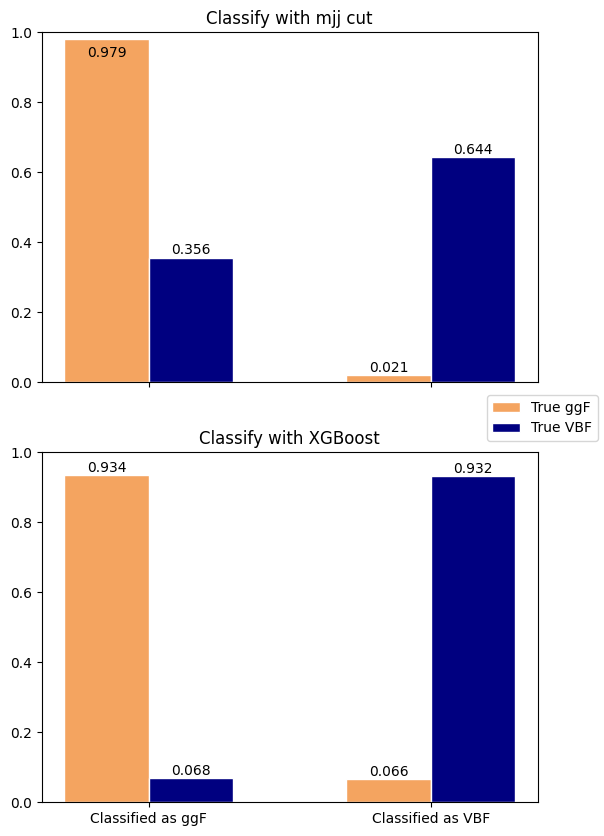

In [133]:
# two barplots together
barWidth = 0.3
i=0
if i:
    labels = ["Classified as ggF", "Classified as VBF", "Not used"]
    bars1 = np.array([w_ggf_as_ggf[i], w_ggf_as_vbf[i], w_ggf_else[i]])/w_true_ggf
    bars2 = np.array([w_vbf_as_ggf[i], w_vbf_as_vbf[i], w_vbf_else[i]])/w_true_vbf
else:
    labels = ["Classified as ggF", "Classified as VBF"]
    bars1 = np.array([w_ggf_as_ggf[i], w_ggf_as_vbf[i]])/w_true_ggf
    bars2 = np.array([w_vbf_as_ggf[i], w_vbf_as_vbf[i]])/w_true_vbf

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

disp.confusion_matrix
ggf_as_ggf_bdt = disp.confusion_matrix[0,0]
ggf_as_vbf_bdt = disp.confusion_matrix[0,1]
vbf_as_ggf_bdt = disp.confusion_matrix[1,0]
vbf_as_vbf_bdt = disp.confusion_matrix[1,1]
bars3 = [ggf_as_ggf_bdt, ggf_as_vbf_bdt]
bars4 = [vbf_as_ggf_bdt, vbf_as_vbf_bdt]

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(6.4, 10))
# fig.suptitle('Aligning x-axis using sharex')
ax1.set_title("Classify with mjj cut")
ax1.bar(r1, bars1, color='sandybrown', width=barWidth, edgecolor='white', label='True ggF')
ax1.bar(r2, bars2, width=barWidth, color="navy", edgecolor='white', label='True VBF')
ax1.set_ylim(0,1)
bars11 = np.concatenate((bars1,bars2))
r11 = np.concatenate((r1,r2))
for i, v in enumerate(bars11):
    if i == 0:
        ax1.text(r11[i] - 0.07, v - 0.05, f"{v:.3f}")
    else:
        ax1.text(r11[i] - 0.07, v + 0.01, f"{v:.3f}")

ax2.set_title("Classify with XGBoost")
ax2.bar(r1, bars3, color='sandybrown', width=barWidth, edgecolor='white', label='True ggF')
ax2.bar(r2, bars4, width=barWidth, color="navy", edgecolor='white', label='True VBF')
ax2.set_ylim(0,1)
bars22 = np.concatenate((bars3,bars4))
for i, v in enumerate(bars22):
    # if i == 0:
    #     ax2.text(r11[i] - 0.07, v - 0.05, f"{v:.3f}")
    # else
    ax2.text(r11[i] - 0.07, v + 0.01, f"{v:.3f}")


# Add xticks on the middle of the group bars
# ax2.set_xlabel('Classification', fontweight='bold')
ax2.set_xticks([r + barWidth/2 for r in range(len(bars1))], labels)
 
# Create legend & Show graphic
fig.legend(labels=["True ggF", "True VBF"], loc="center right")
# plt.show()

# plt.savefig(f"{path}mjj_cut_vs_xgboost.pdf")

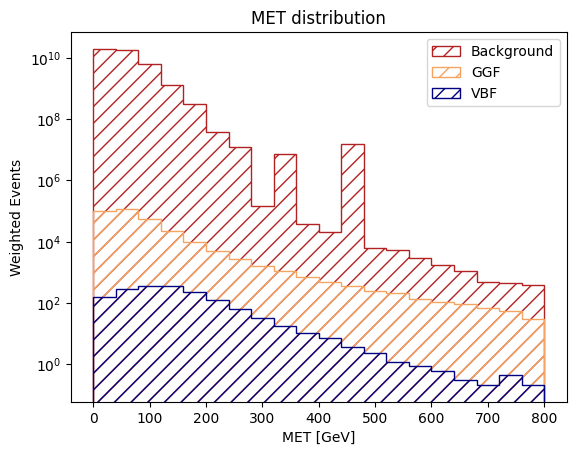

In [78]:
bins = 20
range = (0,800000)
log = True
type = 'step'
hatch = '//'
normalize = False
title = "MET distribution"
if normalize:
    log = False
    title = "Normalized MET distribution"
# plt.hist(x_test_bg[:,3], bins=bins, weights=w_test_bg, range=range, log=log, label="Background",histtype=type, hatch=hatch, density=normalize, color="firebrick")
plt.hist(x_test[:,3][y_test == False], bins=bins, weights=w_test[y_test == False], range=range, log=log, label="GGF",histtype=type, hatch=hatch, density=normalize, color="sandybrown")
plt.hist(x_test[:,3][y_test == True], bins=bins, weights=w_test[y_test == True], range=range, log=log, label="VBF",histtype=type, hatch=hatch, density=normalize, color="navy")
plt.xticks(np.linspace(0,800000,9),np.linspace(0,800,9,dtype='int'))
plt.xlabel("MET [GeV]")
plt.ylabel("Weighted Events")
plt.title(title)
plt.legend()
plt.savefig(f"{path}{title.replace(' ', '_')}")

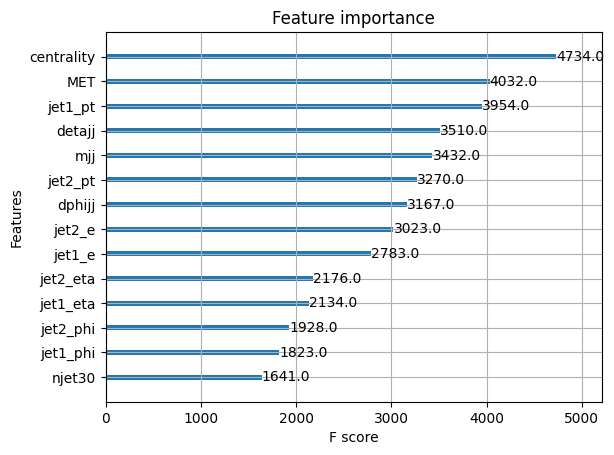

In [14]:
#plot feature importance
reg.get_booster().feature_names = BDT_inputs
xgb.plot_importance(reg)
plt.show()

In [33]:
#plot for mjj and met cuts
cuts_config = config['cuts_config']
data_chain = uproot.lazy([f"output/xgboost/{procees}_{do_cut}_cuts{VBF_cut}.root:miniT" for procees in config['ttree']['files'].keys()])#,array_cache=cache)
# consider only events with weight>0 and at least one dpj
data_chain = aw.flatten(data_chain.mask[data_chain["weight"]>=0], axis=0)

s_as_s = aw.flatten(data_chain.mask[data_chain["isVBF"] == True].mask[data_chain["mjj"]>=cuts_config['min_mjj']].mask[data_chain["MET"]>cuts_config['min_MET']], axis=0)
s_as_b = aw.flatten(data_chain.mask[data_chain["isVBF"] == True].mask[data_chain["mjj"]<cuts_config['min_mjj']].mask[data_chain["MET"]<=cuts_config['min_MET']], axis=0)
b_as_s = aw.flatten(data_chain.mask[data_chain["isVBF"] == False].mask[data_chain["mjj"]>=cuts_config['min_mjj']].mask[data_chain["MET"]>cuts_config['min_MET']], axis=0)
b_as_b = aw.flatten(data_chain.mask[data_chain["isVBF"] == False].mask[data_chain["mjj"]<cuts_config['min_mjj']].mask[data_chain["MET"]<=cuts_config['min_MET']], axis=0)

In [40]:
ss2 = aw.flatten(data_chain.mask[data_chain["mjj"]>=cuts_config['min_mjj'] and data_chain["isVBF"] == True ], axis=0)

ValueError: the truth value of an array whose length is not 1 is ambiguous; use ak.any() or ak.all()

In [38]:
data_chain[-1]

<Record ... dpj_eta: -999, centrality: -999} type='{"weight": float32, "scale1fb...'>

In [31]:
s_as_s_w = np.sum(s_as_s["weight"])
s_as_b_w = np.sum(s_as_b["weight"])
b_as_b_w = np.sum(b_as_b["weight"])
b_as_s_w = np.sum(b_as_s["weight"])

s_w = np.sum(data_chain["weight"].mask[data_chain["isVBF"] == True])
b_w = np.sum(data_chain["weight"].mask[data_chain["isVBF"] == False])

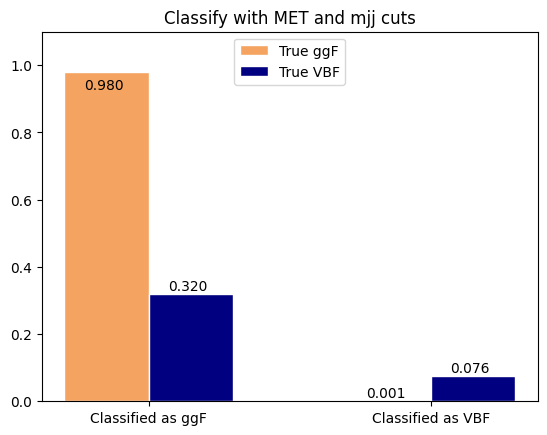

In [32]:
barWidth = 0.3
xh = 0.08
labels = ["Classified as ggF", "Classified as VBF"]
ggf_as_ggf_bdt = b_as_b_w/b_w
ggf_as_vbf_bdt = b_as_s_w/b_w
vbf_as_ggf_bdt = s_as_b_w/s_w
vbf_as_vbf_bdt = s_as_s_w/s_w
# bg_as_vbf_bdt = disp_bg.confusion_matrix[0,1]/w_true_bg
# bg_as_ggf_bdt = disp_bg.confusion_matrix[0,0]/w_true_bg
bars1 = [ggf_as_ggf_bdt, ggf_as_vbf_bdt]
bars2 = [vbf_as_ggf_bdt, vbf_as_vbf_bdt]
# bars3 = [bg_as_ggf_bdt, bg_as_vbf_bdt]
title = "Classify with MET and mjj cuts"
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
# r3 = [x + barWidth for x in r2]

# Make the plot
plt.figure()
plt.bar(r1, bars1, color='sandybrown', width=barWidth, edgecolor='white', label='True ggF')
plt.bar(r2, bars2, width=barWidth, color="navy", edgecolor='white', label='True VBF')
# plt.bar(r3, bars3, width=barWidth, color='firebrick', edgecolor='white', label='Background')
plt.title(title)
# Add xticks on the middle of the group bars
# plt.xlabel('Classification', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], labels)
bars11 = np.concatenate((bars1,bars2))#,bars3))
r11 = np.concatenate((r1,r2))#,r3))
plt.ylim(0,1.1)
for j, v in enumerate(bars11):
    if v > 0.95:
        plt.text(r11[j] - xh, v - 0.05, f"{v:.3f}")
    else:
        plt.text(r11[j] - xh, v + 0.01, f"{v:.3f}")

# Create legend & Show graphic
plt.legend(loc='upper center')